In [12]:
#!usr/bin/env python3
# Author: Paulo Quilao
# MS Geomatics Engineering Thesis
# Module for prepartion of datasets for neural network


# Import necessary packages
import os
import glob
import gdal
import numpy as np


# Helper functions
def convert_layer(filepath) -> np.ndarray:
    """Converts image file to an array."""
    try:
        # Read params using gdal and convert band 1 to np array
        image = gdal.Open(filepath)
        if image is None:
            print("Cannot locate image.")
            return
        # Convert raster to numpy array
        layer = image.GetRasterBand(1).ReadAsArray()

    except Exception as e:
        print(repr(e))

    finally:
        # Close dataset
        image = None

    return layer


def get_path_ds(filepath, extension):
    """Returns path of tif image."""
    ds_path = glob.glob(os.path.join(filepath, extension))
    # assert len(ds_path) == 9, "Path should contain 9 files"
    return ds_path


def get_relevant_val(array):
    """Returns an array with nontrivial scalars."""
    import warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning)

    array = array[array > -999]
    return array

# end of helper functions


# Class for preparation of datasets
class Dataset:
    def __init__(self, prone, notprone):
        self.prone = prone
        self.notprone = notprone
        self.file_ext = "*.tif"

    def set_file_ext(self, extension):
        """Alters the default image file extension (i.e. .tif)."""
        self.file_ext = extension

    def load_layers(self):
        """Prepare layers for neural network model."""

        # Read all landslide drivers
        print("Loading layers for the creation of input vector...")
        print()

        # Path to datasets
        ds_prone = get_path_ds(self.prone, self.file_ext)
        ds_np = get_path_ds(self.notprone, self.file_ext)

        # Prone datasets
        X_p = []
        for image in ds_prone:
            X_p.append(convert_layer(image))

        # Not prone datasets
        X_np = []
        for image in ds_np:
            X_np.append(convert_layer(image))

        # Check shape of each array if read correctly
        # Expected output:(6334, 3877)
        # If the list is not empty
        if X_p and X_np:
            print("Shape of converted layers to numpy array:")
            flag = True
            for factor1, factor2 in zip(X_p, X_np):
                assert factor1.shape == factor2.shape, "Vectorized images should have the same shape."
                flag = True
        if flag:
            print("prone factor: {}, not prone factor: {}".format(X_p[0].shape, X_np[0].shape))
            print()

        else:
            print("Error in input images.")

        # Convert arrays to row vector
        # Landslide prone samples
        X_p_flat = []
        for factor in X_p:
            X_p_flat.append(factor.flatten().astype("float32"))

        # Not prone to landslide samples
        X_np_flat = []
        for factor in X_np:
            X_np_flat.append(factor.flatten().astype("float32"))

        # Get flattened shape and dtype
        if X_p_flat and X_np_flat:
            print("Converting arrays to 1D arrays...")
            flag = True
            for vector1, vector2 in zip(X_p_flat, X_np_flat):
                assert vector1.shape == vector2.shape, "Row vectors should have the same shape."
                flag = True

        if flag:
            print("Shape of 1D arrays:")
            print(f"prone factor: {X_p_flat[0].shape}, dtype: {X_p_flat[0].dtype} | not prone factor: {X_np_flat[0].shape}, dtype: {X_np_flat[0].dtype}")
            print()

        # Boolean filtering
        # Get "non-nodata" values for each factor
        print("Applying boolean filtering to 1D arrays...")
        for i in range(len(X_p_flat)):
            X_p_flat[i] = get_relevant_val(X_p_flat[i])
            X_np_flat[i] = get_relevant_val(X_np_flat[i])

        # Add columns to those factors with less than columns of relevant dataset
        for i in range(len(X_np_flat)):
            ref = X_p_flat[0].shape[0]
            col = X_np_flat[i].shape[0]
            if col != ref:
                X_np_flat[i] = np.concatenate((X_np_flat[i], [np.mean(X_np_flat[i])] * (ref - col)))

        # Get filtered shape and dtype
        if X_p_flat and X_np_flat:
            flag = True
            for vector1, vector2 in zip(X_p_flat, X_np_flat):
                assert vector1.shape == vector2.shape, "Row vectors should have the same shape."
                flag = True

        if flag:
            print("Shape of filtered 1D arrays:")
            print(f"prone factor: {X_p_flat[0].shape}, dtype: {X_p_flat[0].dtype} | not prone factor: {X_np_flat[0].shape}, dtype: {X_np_flat[0].dtype}")
            print()

        # Scale values of each row vector
        print("Scaling all input vectors using min-max scaling...")
        X_p_norm = []
        X_np_norm = []
        for i in range(len(X_p)):
            norm_p = (X_p_flat[i] - min(X_p_flat[i])) / (max(X_p_flat[i]) - min(X_p_flat[i]))
            norm_np = (X_np_flat[i] - min(X_np_flat[i])) / (max(X_np_flat[i]) - min(X_np_flat[i]))

            X_p_norm.append(norm_p)
            X_np_norm.append(norm_np)
        print("All vectors are scaled in the interval [0, 1].")
        print()

        X_p = np.vstack(X_p_norm).T.astype("float32")
        X_np = np.vstack(X_np_norm).T.astype("float32")

        print(f"Landslide prone input vector: {X_p.shape} and data type: {X_p.dtype} \nNot prone to landslide input vector: {X_np.shape} and data type {X_np.dtype}")
        print()

        # Split dataset to training set and testing set
        print("Splitting samples to training, validation, and testing sets...")
        train_split = int(0.8 * X_p.shape[0])  # 80% of total dataset

        X_p_split = np.split(X_p, [train_split])
        X_p_train = X_p_split[0]  # get the 80% of the dataset
        X_p_test = X_p_split[1]  # get the remaining 80% of the dataset

        X_np_split = np.split(X_np, [train_split])
        X_np_train = X_np_split[0]
        X_np_test = X_np_split[1]

        X_train = np.vstack([X_p_train, X_np_train])
        X_test = np.vstack([X_p_test, X_np_test])

        # These target values resulted to continuous lsi (probability between 0.1 to 0.9)
        # For one output node with 0.1 and 0.9 target values
        # 0.1 -> absence of landslide; 0.9 -> presence of landslide
        y_p_train = np.full(X_p_train.shape[0], 0.9, dtype="float32")
        y_p_test = np.full(X_p_test.shape[0], 0.9, dtype="float32")

        y_np_train = np.full(X_np_train.shape[0], 0.1, dtype="float32")
        y_np_test = np.full(X_np_test.shape[0], 0.1, dtype="float32")

        y_train = np.concatenate([y_p_train, y_np_train])
        y_train = np.vstack(y_train)
        y_test = np.concatenate([y_p_test, y_np_test])
        y_test = np.vstack(y_test)

        # Check if the total number of dataset matched with training and testing sets
        assert (X_train.shape[0] + X_test.shape[0]) == (X_p.shape[0] + X_np.shape[0]), "Number of rows should match the total number of datasets."
        assert (X_train.shape[1] == X_p.shape[1]) and (X_test.shape[1] == X_p.shape[1]), "Number of columns should match the total number of datasets."

        print("Finalizing samples...")
        # Create a union of X and y vectors
        dataset_train = np.concatenate((X_train, y_train), axis=1)
        dataset_test = np.concatenate((X_test, y_test), axis=1)

        # Shuffle datasets
        np.random.shuffle(dataset_train)
        np.random.shuffle(dataset_test)

        # For 1 output node
        X_train_1o = dataset_train[..., :10]
        y_train_1o = dataset_train[..., [-1]]

        # Split train into train and validation sets
        # 80:20 ratio
        train_val_split = int(0.8 * X_train_1o.shape[0])
        X_train_split = np.split(X_train_1o, [train_val_split])
        y_train_split = np.split(y_train_1o, [train_val_split])

        # X vector
        X_train_1o = X_train_split[0]
        X_val_1o = X_train_split[1]

        # y vector
        y_train_1o = y_train_split[0]
        y_val_1o = y_train_split[1]

        # X and y test sets
        X_test_1o = dataset_test[..., :10]
        y_test_1o = dataset_test[..., [-1]]

        if X_train_1o.shape[0] == y_train_1o.shape[0] and X_test_1o.shape[0] == y_test_1o.shape[0] and X_val_1o.shape[0] == y_val_1o.shape[0]:
            print("Datasets created with shape: train={}, val={}, test={}".format(X_train_1o.shape, X_val_1o.shape, y_test_1o.shape))
            print()

        else:
            print("Error in dataset shapes.")

        # For one output node
        # Merge final train, test, and validation datasets (excluding validation set)
        # For shuffling in training regimen
        train_xy = np.concatenate([X_train_1o, y_train_1o], axis=1)
        val_xy = np.concatenate([X_val_1o, y_val_1o], axis=1)
        test_xy = np.concatenate([X_test_1o, y_test_1o], axis=1)

        return [train_xy, val_xy, test_xy]

    def load_fuzzified_layers(self, path):
        """Prepare arrays for lsi generation"""
        lsi_path = get_path_ds(path, self.file_ext)

        # Read all landslide drivers
        X_raw = []
        for factor in lsi_path:
            X_raw.append(convert_layer(factor))

        # Convert to 1D array
        X_lsi_flat = []
        for array in X_raw:
            X_lsi_flat.append(array.flatten())

        # Create input vector X from all contributing factors
        x_lsi = np.vstack(X_lsi_flat).T.astype("float32")
        # Finalize datasets
        y_lsi = x_lsi[..., [-1]]
        x_lsi = x_lsi[..., :-1]

        return [x_lsi, y_lsi]

# end of Dataset class


def main():
    # Filepath for landslide prone and nonprone samples
    fp_prone = r"D:\ms gme\thesis\final parameters\samples\Final\landslide"
    fp_notprone = r"D:\ms gme\thesis\final parameters\Samples\Final\no_landslide"

    my_thesis = Dataset(fp_prone, fp_notprone)
    datasets = my_thesis.load_layers()

    return datasets


if __name__ == "__main__":
    pass
    # main()


In [19]:
#!/usr/bin/env python3
# Author: Paulo Quilao
# MS Geomatics Engineering Thesis
# Simulation of landslides using a two-layer neural network


# Import necessary packages
import os
import sys
import gdal
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import copy
# from dataset import *  # user-defined module


# Neural network parent class
class Neural_Network(object):
    def __init__(self, *args):
        ''' Initialization of the perceptron with given sizes.  '''

        self.shape = args
        n = len(args)

        # Build layers
        self.layers = []
        # Input layer (+1 unit for bias)
        self.layers.append(np.ones(self.shape[0]+1))
        # Hidden layer(s) + output layer
        for i in range(1,n):
            self.layers.append(np.ones(self.shape[i]))

        # Build weights matrix (randomly between -0.25 and +0.25)
        self.weights = []
        for i in range(n-1):
            self.weights.append(np.zeros((self.layers[i].size,
                                         self.layers[i+1].size)))

        # dw will hold last change in weights (for momentum)
        self.dw = [0,]*len(self.weights)

        # Reset weights
        self.reset()
        
        # Date/time information for exporting
        dt = datetime.datetime.now()
        self.date = dt.strftime("%x")  # local date
        self.time = dt.strftime("%X")  # local time

    def reset(self):
        ''' Reset weights '''

        for i in range(len(self.weights)):
            Z = np.random.random((self.layers[i].size,self.layers[i+1].size))
            self.weights[i][...] = (2*Z-1)*0.25
            
    # Training methods
    # Activation function in output layer
    def sigmoid(self, s):
        """Logistic activation function."""
        return 1 / (1 + np.exp(-s))

    def sigmoid_prime(self, s):
        """Derivative of logistic function."""
        return self.sigmoid(s) * (1 - self.sigmoid(s))

    # Activation function in hidden layer
    def lrelu(self, x):
        """Leaky rectified linear unit."""
        return np.where(x > 0, x, x * 0.01)

    def lrelu_prime(self, x):
        """Derivative of leaky rectified linear unit."""
        dx = np.ones_like(x)
        dx[x < 0] = 0.01
        return dx
    
    def forward(self, data):
        ''' Propagate data from input layer to output layer. '''

        # Set input layer
        self.layers[0][0:-1] = data

        # Propagate from layer 0 to layer n-1 using lrelu as activation function
        for i in range(1,len(self.shape)):
            # Propagate activity
            self.layers[i][...] = self.lrelu(np.dot(self.layers[i-1],self.weights[i-1]))

        # Return output
        return self.layers[-1]

    def backward(self, target, lrate=0.01, momentum=0.9):
        ''' Back propagate error related to target using lrate. '''

        deltas = []

        # Compute error on output layer
        error = target - self.layers[-1]
        delta = error*self.sigmoid_prime(self.layers[-1])
        deltas.append(delta)

        # Compute error on hidden layers
        for i in range(len(self.shape)-2,0,-1):
            delta = np.dot(deltas[0],self.weights[i].T)*self.lrelu_prime(self.layers[i])
            deltas.insert(0,delta)

        # Update weights
        for i in range(len(self.weights)):
            layer = np.atleast_2d(self.layers[i])
            delta = np.atleast_2d(deltas[i])
            dw = np.dot(layer.T, delta)
            self.weights[i] += lrate*dw + momentum*self.dw[i]
            self.dw[i] = dw

        # Return error
        return np.sqrt(np.mean(error**2))

    def compute_error(self, X, y):
        """Computes RMSE of feeded dataset after a full pass."""
        feed = self.forward(X)
        error = np.sqrt(np.mean((y - feed)**2))
        return error

    def predict(self, test_x, test_y):
        """Simulates y based on feeded testing data."""
        print("Predicted data based on trained weights:")
        print("Predicted values: {}\n".format(self.forward(test_x)))
        print("Target values: {}\n".format(test_y))
        rmse = self.compute_error(test_x, test_y)
        print("Testing loss: {}\n".format(rmse))

    # end of training methods

    # Plot method
    def plot_loss_curve(self, xlabel, ylabel, name, save=True):
        """Creates a loss curve plot."""
        plt.figure(figsize=(10, 5))
        plt.plot(self.loss_train, label="Training Loss")
        plt.plot(self.loss_val, label="Validation Loss")
        plt.title(f"h={self.hidden_size}, lrate={self.lrate}, momentum={self.momentum}")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend(loc=1)

        if save:
            # Save plot
            folder = "plots"
            op = os.path.join(os.getcwd(), folder)

            if not os.path.exists(op):
                os.makedirs(folder)

            suffix = f"{str(self.hidden_size)}_{str(self.lrate)}_{str(self.momentum)}"

            if not os.path.isfile(os.path.join(op, name)):
                plt.savefig(os.path.join(op, f"{name}_{suffix}.jpg"))
            else:
                print("Name already exists.")

        plt.show()

    # Write methods
    def save_predict(self, test_x, test_y):
        """Saves a summary of results based on simulated testing data."""
        folder = "runs"
        op = os.path.join(os.getcwd(), folder)

        if not os.path.exists(op):
            os.makedirs(folder)

        # Predicted
        with open(os.path.join(op, "predict.txt"), "a") as pred:
            pred.write("Date and time: {}, {}\n".format(self.date, self.time))
            pred.write("Optimizer: {}\n".format(type(self).__name__))
            pred.write("NN structure: {}\n".format(self.layers))
            pred.write("lrate={}, ".format(self.lrate))
            pred.write("momentum={}, ".format(self.momentum))
            rmse = self.compute_error(test_x, test_y)
            pred.write("error: {}\n\n".format(rmse))

    def save_summary(self, filename, layers: list):
        """Exports the training summary."""
        folder = "runs"
        op = os.path.join(os.getcwd(), folder)

        if not os.path.exists(op):
            os.makedirs(folder)

        # Compute weight of each factor
        m_ave = []
        m_max = []
        weights = self.W1

        for w in weights:
            m_ave.append(np.mean(w))
            m_max.append(np.amax(w))

        # Map weights to factors
        f = layers
        d_ave = dict(zip(f, m_ave[:-1]))    # exclude bias, average weight
        d_max = dict(zip(f, m_max[:-1]))    # exclude bias, max weight

        # Save weights if error in testing data is reasonable
        with open(os.path.join(op, filename), "a") as data:
            data.write("Date and time: {}, {}\n".format(self.date, self.time))
            data.write("NN structure: {}\n".format(self.layers[:-1]))
            data.write("Hyperparameters: ")
            data.write("lrate={}, ".format(self.lrate))
            data.write("mu={}, ".format(self.momentum))

            try:
                # For MGD
                data.write("batch size={}".format(self.batch_size))
                data.write("\nCycle: {} for 1 epoch (max of {}), ".format(self.total_batch, epoch))
                data.write("terminated at epoch={}, iteration={}".format(self.term_epoch, self.term_iter))

            except AttributeError:
                # For SGD and BGD
                data.write("\nEpoch={}, terminated at:{}".format(self.epoch, self.term_epoch))

            data.write("\nSet and actual errors: ")
            data.write("RMSE: {}, ".format(self.rmse))
            data.write("val error: {}\n".format(np.amin(self.loss_val)))
            data.write("Input to hidden weights:\n {}\n".format(self.W1))
            data.write("Hidden to output weights:\n {}\n".format(self.W2))
            data.write("Weight of each layer (ave):\n {}\n".format(d_ave))
            data.write("Weight of each layer (max):\n {}\n\n".format(d_max))

        # Check if the file exists
        assert os.path.isfile(os.path.join(op, filename)), "The file was not created."
        print("\nSummary of training was exported.")

    def export_to_image(self, ref_path, out_path, array):
        """Exports array to image (default GeoTiff)."""
        print("\nExporting array to image...")

        # Reference data
        data0 = gdal.Open(ref_path)

        if data0 is None:
            print("No reference data.")
            sys.exit(1)

        # get rows and columns of array
        row = array.shape[0]  # number of pixels in y
        col = array.shape[1]  # number of pixels in x

        driver = gdal.GetDriverByName('GTiff')
        dataset = driver.Create(out_path, col, row, 1, gdal.GDT_Float32)

        if dataset is None:
            print("Could not create lsi.tif")
            sys.exit(1)

        dataset.GetRasterBand(1).WriteArray(lsi)
        dataset.GetRasterBand(1).SetNodataValue(-9999)

        # Add GeoTranform and Projection
        geotrans = data0.GetGeoTransform()  # get GeoTranform from ref 'data0'
        proj = data0.GetProjection()  # get GetProjection from ref 'data0'
        dataset.SetGeoTransform(geotrans)
        dataset.SetProjection(proj)
        dataset.FlushCache()
        dataset = None

        # Check if exported correctly
        if os.path.isfile(out_path):
            print("\nLandslide susceptility index was exported.")

    # Getters
    def get_structure(self):
        """Returns the initialized NN structure."""
        return self.layers

    def get_weights(self):
        """Returns the weights of the model."""
        return [self.W1, self.W2]

    def get_lrate(self):
        """Returns the set learning rate."""
        return self.lrate

    def get_momentum(self):
        """Returns the set momentum factor."""
        return self.momentum

    # Setters
    def set_weights(self, weight):
        """Set the weights for final forward pass (excluding bias weights)."""
        self.W1 = weight[0][0:-1]  # exclude the bias for lsi prediction
        self.W2 = weight[1]

# end of Neural_Network class


# Class optimizers
class BGD(Neural_Network):
    """Batch Gradient Descent."""

    def train_BGD(self, *args):
        """Performs simulation using batch gradien descent."""

        print(f"\nStarting BGD Training with NN structure:{self.layers}, lrate={self.lrate}, mu={self.momentum}:")
        training = args[0][0]
        validation = args[0][1]

        self.rmse = args[1]
        self.epoch = args[2]

        # X and y training sets
        X_train_1o = training[..., :10]
        y_train_1o = training[..., [-1]]

        # X and y validation sets
        X_val_1o = validation[..., :10]
        y_val_1o = validation[..., [-1]]

        self.loss_train = []
        self.loss_val = []

        for i in range(epoch):
            # Shuffle training set every epoch
#             np.random.shuffle(training)

            # Training loss
            rmse_train = self.train(X_train_1o, y_train_1o)

            # Validation loss
            rmse_val = self.compute_error(X_val_1o, y_val_1o)

            # Store errors
            self.loss_val.append(rmse_val)
            self.loss_train.append(rmse_train)

            # Print result per epoch
            print("epoch: {}".format(i))
            print("Training Loss: {}".format(rmse_train))
            print("Validation Loss: {}".format(rmse_val))
            print()

            # Threshold error
            if rmse_val <= self.rmse:
                break

        # Termination information
        self.term_epoch = i

        # Training statistics
        min_loss_train = np.amin(self.loss_train)
        max_loss_train = np.amax(self.loss_train)
        mean_loss_train = np.mean(self.loss_train)
        min_val_train = np.amin(self.loss_val)
        max_val_train = np.amax(self.loss_val)
        mean_val_train = np.mean(self.loss_val)

        print("\nTraining statistics:")
        print("Minimum train error:", min_loss_train)
        print("Maximum train error:", max_loss_train)
        print("Mean train error:", mean_loss_train)
        print()
        print("Minimum val error:", min_val_train)
        print("Maximum val error:", max_val_train)
        print("Mean val error:", mean_val_train)


class SGD(Neural_Network):
    """Stochastic Gradient Descent."""

    def train_SGD(self, *args):
        """Performs simulation using stochastic gradien descent."""
        print(f"\nStarting SGD Training with NN structure:{self.layers}, lrate={self.lrate}, mu={self.momentum}:")
        training = args[0][0]
        validation = args[0][1]

        self.rmse = args[1]
        self.epoch = args[2]

        # X and y training sets
        X_train_1o = training[..., :10]
        y_train_1o = training[..., [-1]]

        # X and y validation sets
        X_val_1o = validation[..., :10]
        y_val_1o = validation[..., [-1]]

        self.loss_train = []
        self.loss_val = []

        for i in range(epoch):
            # Stochastic sampling
            n = np.random.choice(X_train_1o.shape[0])

            # Training loss
            rmse_train = self.train(X_train_1o[n], y_train_1o[n])

            # Validation loss
            rmse_val = self.compute_error(X_val_1o, y_val_1o)

            # Store errors
            self.loss_val.append(rmse_val)
            self.loss_train.append(rmse_train)

            # Print result per epoch
            print("epoch: {}".format(i))
            print("Training Loss: {}".format(rmse_train))
            print("Validation Loss: {}".format(rmse_val))
            print()

            # Threshold error
            if rmse_val <= self.rmse:
                break

        # Termination information
        self.term_epoch = i

        # Training statistics
        min_loss_train = np.amin(self.loss_train)
        max_loss_train = np.amax(self.loss_train)
        mean_loss_train = np.mean(self.loss_train)
        min_val_train = np.amin(self.loss_val)
        max_val_train = np.amax(self.loss_val)
        mean_val_train = np.mean(self.loss_val)

        print("\nTraining statistics:")
        print("Minimum train error:", min_loss_train)
        print("Maximum train error:", max_loss_train)
        print("Mean train error:", mean_loss_train)
        print()
        print("Minimum val error:", min_val_train)
        print("Maximum val error:", max_val_train)
        print("Mean val error:", mean_val_train)


class MGD(Neural_Network):
    """Mini-batch Gradient Descent."""

    def __init__(self, *args, **kwargs):
        Neural_Network.__init__(self, *args)
        self.batch_size = kwargs["bs"]

    def train_MGD(self, *args):
        """Performs simulation using mini-batch gradien descent."""
#         print(f"\nStarting MGD Training with NN structure:{self.layers}, lrate={self.lrate}, mu={self.momentum}:")

        training = args[0][0]
        validation = args[0][1]

        self.rmse = args[1]
        self.epoch = args[2]

        # X and y training sets
        X_train_1o = training[..., :9]
        y_train_1o = training[..., [-1]]

        # X and y validation sets
        X_val_1o = validation[..., :9]
        y_val_1o = validation[..., [-1]]

        # Initialize number of iterations
        self.total_batch = X_train_1o.shape[0] // (self.batch_size - 1)  # exlude the last index
        val_batch = X_val_1o.shape[0] // (self.batch_size - 1)

        self.loss_train = []
        self.loss_val = []
        for i in range(epoch):

            # Shuffle datasets each epoch (after completely seeing the entire dataset)
            np.random.shuffle(training)

            # Reassign X and y training vectors
            X_train_1o = training[..., :9]
            y_train_1o = training[..., [-1]]

            X_batches = np.array_split(X_train_1o, self.total_batch)
            y_batches = np.array_split(y_train_1o, self.total_batch)

            # Initialize rmse
            # Will be reset after completing 1 epoch
            ave_cost_train = 0

            # Train the neural network per mini-batch
            for j in range(self.total_batch):
                minibatch_x = X_batches[j]
                minibatch_y = y_batches[j]

                # Train per mini-batch
                self.forward(minibatch_x)
                rmse_train = self.backward(minibatch_y)

                # Get average training cost for each epoch
                ave_cost_train += rmse_train / self.total_batch

            self.loss_train.append(ave_cost_train)

#             # Validation using the whole validation set
#             rmse_val = self.compute_error(X_val_1o, y_val_1o)
#             self.loss_val.append(rmse_val)

#             # Print result per epoch
#             print("epoch: {}".format(i))
#             print("Training loss: {}".format(ave_cost_train))
#             print("Validation loss: {}".format(rmse_val))
#             print()

#             if rmse_val <= RMSE:
#                 break

            # Per mini-batch validation
            ave_cost_val = 0
        
            x_val = np.array_split(X_val_1o, val_batch)
            y_val = np.array_split(y_val_1o, val_batch)
            
            for v in range(val_batch):
                mb_val_x = x_val[v]
                mb_val_y = y_val[v]

                # Validation loss
                rmse_val = self.compute_error(mb_val_x, mb_val_y)

                # Get average val cost for each epoch
                ave_cost_val += rmse_val / val_batch

            self.loss_val.append(ave_cost_val)

            # Print result per epoch
            print("epoch: {}".format(i))
            print("Training loss: {}".format(ave_cost_train))
            print("Validation loss: {}".format(ave_cost_val))
            print()

            # Stoping criterion using validation set
            if ave_cost_val <= self.rmse:
                print("Training done.")
                break

        # Termination information
        self.term_epoch = i
        self.term_iter = j

        # Training statistics
        min_loss_train = np.amin(self.loss_train)
        max_loss_train = np.amax(self.loss_train)
        mean_loss_train = np.mean(self.loss_train)
        min_val_train = np.amin(self.loss_val)
        max_val_train = np.amax(self.loss_val)
        mean_val_train = np.mean(self.loss_val)

        print("\nTraining statistics:")
        print("Minimum train error:", min_loss_train)
        print("Maximum train error:", max_loss_train)
        print("Mean train error:", mean_loss_train)
        print()
        print("Minimum val error:", min_val_train)
        print("Maximum val error:", max_val_train)
        print("Mean val error:", mean_val_train)

# end of class optimizers

In [13]:
if __name__ == "__main__":
    # Start time
    start_time = time.process_time()

    # Filepath for landslide prone and nonprone samples
    fp_prone = r"D:\ms gme\thesis\final parameters\samples\Final\landslide\fixed_nd"
    fp_notprone = r"D:\MS Gme\Thesis\Final Parameters\Samples\Final\no_ls_5deg_slope\fixed_nd"

    my_thesis = Dataset(fp_prone, fp_notprone)

    # Load landslide factors
    datasets = my_thesis.load_layers()
    train_val_sets = datasets[0:2]
    test_set = datasets[2]


Loading layers for the creation of input vector...

Shape of converted layers to numpy array:
prone factor: (6334, 3877), not prone factor: (6334, 3877)

Converting arrays to 1D arrays...
Shape of 1D arrays:
prone factor: (24556918,), dtype: float32 | not prone factor: (24556918,), dtype: float32

Applying boolean filtering to 1D arrays...
Shape of filtered 1D arrays:
prone factor: (18862,), dtype: float32 | not prone factor: (18862,), dtype: float32

Scaling all input vectors using min-max scaling...
All vectors are scaled in the interval [0, 1].

Landslide prone input vector: (18862, 9) and data type: float32 
Not prone to landslide input vector: (18862, 9) and data type float32

Splitting samples to training, validation, and testing sets...
Finalizing samples...
Datasets created with shape: train=(24142, 10), val=(6036, 10), test=(7546, 1)



In [20]:
if __name__ == "__main__":
    # MGD training
    # Initiate seed for easier debugging
    seed = 99
    np.random.seed(seed)
    
    # Instantiate NN class
    in_size = 9  # input layer
    h_size = 25  # hidden layer
    out_size = 1  # output layer

    # Hyperparameters
    lrate = 0.01
    momentum = 0.9
    batch_size = 2
    
    mgd = MGD(in_size, h_size, out_size, bs=batch_size, lr=lrate, mu=momentum)

    # Initialize Root Mean Square Error
    RMSE = 0.01
    # Initialize number of epochs
    epoch = 3000

    mgd.train_MGD(train_val_sets, RMSE, epoch)
    # end of training

    

epoch: 0
Training loss: 0.1072677957727713
Validation loss: 0.05613573408365431

epoch: 1
Training loss: 0.07257898523610608
Validation loss: 0.04746135105933431

epoch: 2
Training loss: 0.06856133267821064
Validation loss: 0.05667740553630302

epoch: 3
Training loss: 0.06621271523406787
Validation loss: 0.0925043114166798

epoch: 4
Training loss: 0.06461782097119437
Validation loss: 0.08383637248086047

epoch: 5
Training loss: 0.06467282046547838
Validation loss: 0.06407582343294611

epoch: 6
Training loss: 0.0631208803546886
Validation loss: 0.04622215569689785

epoch: 7
Training loss: 0.06225106733287074
Validation loss: 0.045468055814292606

epoch: 8
Training loss: 0.05951900441199851
Validation loss: 0.15674076367298626

epoch: 9
Training loss: 0.05828708377015309
Validation loss: 0.04412351239328937

epoch: 10
Training loss: 0.05812221200667808
Validation loss: 0.04331011532902586

epoch: 11
Training loss: 0.05684239232609368
Validation loss: 0.0393398589389531

epoch: 12
Trainin

epoch: 99
Training loss: 0.03340521558291334
Validation loss: 0.03188666694272669

epoch: 100
Training loss: 0.03326512729774236
Validation loss: 0.03198005175417944

epoch: 101
Training loss: 0.03304753380308821
Validation loss: 0.029370582993031455

epoch: 102
Training loss: 0.03333004142229438
Validation loss: 0.036488378795959085

epoch: 103
Training loss: 0.03329681583248204
Validation loss: 0.029136197510397793

epoch: 104
Training loss: 0.0334218159228924
Validation loss: 0.039550350748277244

epoch: 105
Training loss: 0.033266098699600434
Validation loss: 0.029052376287487486

epoch: 106
Training loss: 0.03306139443220867
Validation loss: 0.027009661130654186

epoch: 107
Training loss: 0.03304329201570473
Validation loss: 0.032919583258188174

epoch: 108
Training loss: 0.03283810718231069
Validation loss: 0.028936527139783244

epoch: 109
Training loss: 0.03268211018735009
Validation loss: 0.028002154264016393

epoch: 110
Training loss: 0.03176110058980071
Validation loss: 0.042

KeyboardInterrupt: 

In [ ]:
if __name__ == "__main__":
    # BGD training
    # Initiate seed for easier debugging
    seed = 99
    np.random.seed(seed)
    
    # Instantiate NN class
    in_size = 9  # input layer
    h_size = 25  # hidden layer
    out_size = 1  # output layer

    # Hyperparameters
    lrate = 0.001
    momentum = 0.9
    
    bgd = BGD(in_size, h_size, out_size, lr=lrate, mu=momentum)

    # Initialize Root Mean Square Error
    RMSE = 0.01
    # Initialize number of epochs
    epoch = 3000

    bgd.train_BGD(train_val_sets, RMSE, epoch)
    # end of training

    

AttributeError: 'MGD' object has no attribute 'hidden_size'

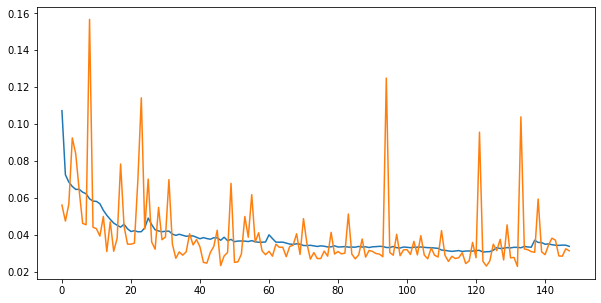

In [21]:
if __name__ == "__main__":
    # Plot loss curve
    xlabel = "Epoch"
    ylabel = "Average Cost"
    name = "MGD_leaky_newsample_mlp"
    mgd.plot_loss_curve(xlabel, ylabel, name, save=True)

    # Predict using testing samples
    # Forward pass using the whole dataset
    X_test_1o = test_set[..., :9]
    y_test_1o = test_set[..., [-1]]

    mgd.predict(X_test_1o, y_test_1o)

    # Write results to disk
    # Predicted
    mgd.save_predict(X_test_1o, y_test_1o)

    # Summary of results
    # Get layers name with the same index as input vector
    layers = [file for file in os.listdir(fp_prone) if os.path.isfile(os.path.join(fp_prone, file))][:-1]  #exclude "readme.txt" file
    filename = "runs_MGD_leaky_mlp.txt"
    mgd.save_summary(filename, layers)

    # Plot target and predicted values
    plt.figure(figsize=(10, 5))
    plt.xlabel("Test samples")
    plt.ylabel("Cell Value")

    x, y = copy.deepcopy(X_test_1o), copy.deepcopy(y_test_1o)

    # Draw target values
    plt.plot(y, "o", color="b", label="Target value")

    # Draw network output values
    loss_testing = []
    
    for i in range(X_test_1o.shape[0]):
        y[i] = mgd.forward(x[i])
        rmse = np.sqrt(np.mean((y_test_1o[i] - y[i])**2)) 
        loss_testing.append(rmse)
    
    mean_error = np.mean(loss_testing)
        
    plt.plot(y, '.', color='r', alpha=0.6, label="Predicted value")

    plt.legend(loc=2)
    # Save plot
    op = r"D:\MS Gme\Thesis\Final Parameters\ANN\sublime_run\jupyter_notebook\plots"
    fn = f"{h_size}_{mgd.get_lrate()}_{mgd.get_momentum()}_{mgd.term_iter}_{mean_error}"

    if not os.path.isfile(os.path.join(op, fn)):
        plt.savefig(os.path.join(op, f"MGD_leaky_test_newsample_mlp{fn}.jpg"))

    plt.show()
    
    print("-------------------------------------------------------")
    print("\nThe script finished its execution after %.2f seconds" % (time.process_time() - start_time))

In [ ]:
if __name__ == "__main__":
    # Generate LSI using the optimized weights
    print("\nGenerating lsi using the best fit model...")
    fuzzy_path = r"D:\MS Gme\Thesis\Final Parameters\Samples\for_lsi\Fuzzy\fuzzy3"

    lsi_ds = my_thesis.load_fuzzified_layers(fuzzy_path)
    X_lsi = lsi_ds[0]
    y_lsi = lsi_ds[1]

    mgd.set_weights(mgd.get_weights())  # exxlude the bias weights
    # Execute forward pass to the whole area per sample
    for i in range(X_lsi.shape[0]):
        y_lsi[i] = mgd.forward(X_lsi[i])

    # Reshape computed lsi to 2D array
    lsi = y_lsi.reshape(6334, 3877)

    # Export generated lsi
    folder = "lsi"
    out_path = os.getcwd()
    op = os.path.join(out_path, folder)
    if not os.path.exists(op):
        os.mkdir(folder)

    fn = "lsi_MGD_leaky_fuzzy3"
    ref_data = os.path.join(fuzzy_path, "itogon_grid.tif")
    mgd.export_to_image(ref_data, os.path.join(op, fn), lsi)